In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from functools import reduce
import operator

from common_plotting import read_data
from common_analysis import rel_data_cut_index_last, combine_stds_sum, display_full_df
from common_analysis_dcv import analyse_dcv_absolute, analyse_dcv_relative, analyse_dcv_k182, add_dut_neg_and_pos_group
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10,4)
plt.rc('font', size=14)

# Load data

In [2]:
thp_data, data = read_data(['ks3458a1-dcv-log.csv', 'ks3458a1-dcv-mv-log.csv', 'k182-dcv-mv-log.csv', 'ks3458a-dcv-log.csv'])
absolute_data_3458a_1 = data['ks3458a1-dcv-log.csv']
absolute_data_3458a_2 = data['ks3458a-dcv-log.csv']
relative_data_3458a = data['ks3458a1-dcv-mv-log.csv']
relative_data_k182 = data['k182-dcv-mv-log.csv']


# Shared functions

In [3]:
def flatten_relative_dcv_result(rel_results: pd.DataFrame, mean: float, mean_sem:float):
    rows = rel_results.apply(lambda row: {
        (row.name, 'datetime'): row.datetime,
        (row.name, 'mean'): row.mean_in_ppm - mean,
        (row.name, 'sem'): row.sem_in_ppm if mean_sem is None else (combine_stds_sum(np.array(row.sem_in_ppm, mean_sem)) if not np.isnan(row.sem_in_ppm) else np.nan),
        (row.name, 'temperature'): row.temperature,
        (row.name, 'pressure'): row.pressure,
        (row.name, 'humidity'): row.humidity
        },
        axis=1)
    return reduce(operator.ior, rows, {})

def make_abs_measurement_relative(abs_results, meter_name, abs_value=10.0):
    abs_results_without_index = abs_results.reset_index()
    rel_results = abs_results_without_index.drop(['dcv_mean', 'dcv_sem', 'dut'], axis='columns').copy()
    rel_results['mean_in_ppm'] = ((abs_value / abs_results_without_index.dcv_mean) - 1)*1e6
    rel_results['sem_in_ppm'] = abs_results_without_index.dcv_sem / abs_results_without_index.dcv_mean * 1e6
    rel_results['dut_neg_lead'] = meter_name
    rel_results['dut_pos_lead'] = abs_results_without_index.dut
    rel_results.columns = ['temperature', 'pressure', 'humidity', 'datetime', 'mean_in_ppm', 'sem_in_ppm', 'dut_neg_lead','dut_pos_lead']
    return rel_results

def get_result_from_group(result, voltage_references):
    result = pd.concat([result, pd.DataFrame([{
        'mean_in_ppm': 0,
        'sem_in_ppm': combine_stds_sum(result.sem_in_ppm.dropna()),
        'datetime': result.datetime.mean(),
        'temperature': result.temperature.mean(),
        'pressure': result.pressure.mean(),
        'humidity': result.humidity.mean(),
        }], index=['F7001bat'])])
    # results_wo_d4910avg = result[(result.index != 'D4910avg') & (result.index.isin(voltage_references))]
    # population_mean = results_wo_d4910avg.mean_in_ppm.mean()
    # if np.isnan(population_mean):
        # return None
    # population_sem = combine_stds_sum(results_wo_d4910avg.sem_in_ppm)
    # print(f"{result.datetime.mean()} mean: {population_mean}, sem: {population_sem}")
    population_mean = 0
    population_sem = None
    flat_result = flatten_relative_dcv_result(result, population_mean, population_sem)
    return flat_result


def add_pos_and_neg_dut(results, neg_dut):
    results['dut_neg_lead'] = neg_dut
    results['dut_pos_lead'] = results.index
    return results.reset_index(drop=True)


# Main analysis

In [4]:
from common_analysis import abs_data_cut_index_last


k182_rel_data_copy = relative_data_k182.copy()
k182_rel_data_copy['gap'] = k182_rel_data_copy.index.to_series().diff() > pd.Timedelta('3 hours')
k182_rel_data_copy['group'] = k182_rel_data_copy.gap.cumsum()
cut_1 = rel_data_cut_index_last(k182_rel_data_copy, 1, 'F732a2', 'D4910avg', pd.Timedelta('40 minutes'))
k182_rel_data_cut = k182_rel_data_copy[~cut_1].copy()
k182_rel_data_cut['gap'] = k182_rel_data_cut.index.to_series().diff() > pd.Timedelta('3 hours')
k182_rel_data_cut['group'] = k182_rel_data_cut.gap.cumsum()

ag3458a_rel_data = relative_data_3458a.copy()
ag3458a_rel_data['gap'] = ag3458a_rel_data.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_rel_data['group'] = ag3458a_rel_data.gap.cumsum()

ag3458a_1_abs_data = absolute_data_3458a_1.copy()
ag3458a_1_abs_data['gap'] = ag3458a_1_abs_data.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_1_abs_data['group'] = ag3458a_1_abs_data.gap.cumsum()
cut_1 = abs_data_cut_index_last(ag3458a_1_abs_data, 2, 'D4910avg', '10 V', pd.Timedelta('4 minutes'), pd.Timestamp('2021-11-17T21:38:19'))
cut_2 = (ag3458a_1_abs_data.index > pd.Timestamp('2021-11-17T23:49:12')) & (ag3458a_1_abs_data.index < pd.Timestamp('2022-04-18T21:35:20'))
cut_3 = (ag3458a_1_abs_data.index > pd.Timestamp('2022-04-19T02:11:40')) & (ag3458a_1_abs_data.index < pd.Timestamp('2022-08-09T22:49:55'))
cut_4 = ~(ag3458a_1_abs_data.dut_setting.isin(['-10 V', '10 V']))
ag3458a_1_abs_data_cut = ag3458a_1_abs_data[~cut_1 & ~cut_2 & ~cut_3 & ~cut_4].copy()
ag3458a_1_abs_data_cut['gap'] = ag3458a_1_abs_data_cut.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_1_abs_data_cut['group'] = ag3458a_1_abs_data_cut.gap.cumsum()

cut_1 = (absolute_data_3458a_2.index > pd.Timestamp('2021-09-10T10:08:00')) & (absolute_data_3458a_2.index < pd.Timestamp('2021-09-12T22:17:24'))
cut_2 = ~(absolute_data_3458a_2.dut_setting.isin(['-10 V', '10 V']))
ag3458a_2_abs_data = absolute_data_3458a_2[~cut_1 & ~cut_2].copy()
ag3458a_2_abs_data['gap'] = ag3458a_2_abs_data.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_2_abs_data['group'] = ag3458a_2_abs_data.gap.cumsum()

In [5]:
voltage_references = ('F732a1', 'F732a2', 'F732a3', 'D4910avg', 'D4910-1', 'D4910-2', 'D4910-3', 'D4910-4', 'F7001bat')
columns = [(dut, param) for dut in voltage_references for param in ('datetime', 'mean', 'sem', 'temperature', 'pressure', 'humidity')]
results = []
for group in ag3458a_1_abs_data_cut.group.unique():
    group_samples = ag3458a_1_abs_data_cut[ag3458a_1_abs_data_cut.group == group].copy()
    abs_result, _ = analyse_dcv_absolute(group_samples.drop('group', axis=1), 'F7001bat', 'ag3458a_1', with_pressure_and_humidity=True)
    rel_result = make_abs_measurement_relative(abs_result, 'ag3458a_1')
    display(rel_result)
for group in ag3458a_2_abs_data.group.unique():
    group_samples = ag3458a_2_abs_data[ag3458a_2_abs_data.group == group].copy()
for group in ag3458a_rel_data.group.unique():
    group_samples = ag3458a_rel_data[ag3458a_rel_data.group == group].copy()
    result = analyse_dcv_relative(group_samples, 'F7001bat', 10, 'F7001bat', 'ag3458a_1', 0)
    flat_result = get_result_from_group(result, voltage_references)
    if flat_result is None:
        continue
    results.append(flat_result)
for group in k182_rel_data_cut.group.unique():
    group_samples = k182_rel_data_cut[k182_rel_data_cut.group == group].copy()
    result = analyse_dcv_k182(group_samples)
    result_with_pos_and_neg_dut = add_pos_and_neg_dut(result, 'F7001bat')
    display(result_with_pos_and_neg_dut)
    flat_result = get_result_from_group(result, voltage_references)
    if flat_result is None:
        continue
    results.append(flat_result)
orig_max_cols = pd.get_option('display.max_columns')
rel_results = pd.DataFrame(results, columns=pd.MultiIndex.from_tuples(columns))
pd.set_option('display.max_columns', None)
# display(rel_results)
pd.set_option('display.max_columns', orig_max_cols)

,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,33.038991,1019.782891,34.271891,2021-09-13 01:16:11.106514432,-1.049799,0.008031,ag3458a_1,D4910avg


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,30.601058,1027.110595,29.689673,2021-11-15 12:20:37.823304448,-0.540429,0.003639,ag3458a_1,D4910avg


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,27.851310,1025.779504,30.444915,2021-11-17 21:47:34.621198848,-0.656465,0.012114,ag3458a_1,D4910-1
1,27.956858,1025.803233,30.438114,2021-11-17 21:56:25.799262720,-0.599653,0.010989,ag3458a_1,D4910-2
2,28.025066,1025.809169,30.468637,2021-11-17 22:06:19.654903296,-1.010775,0.005371,ag3458a_1,D4910-3
3,28.162754,1026.014973,30.437063,2021-11-17 22:18:33.809083904,-0.440197,0.012676,ag3458a_1,D4910-4
4,28.214252,1025.990268,30.468563,2021-11-17 22:36:28.794583296,-0.580659,0.008679,ag3458a_1,D4910avg
5,28.463376,1026.001442,30.361762,2021-11-17 22:52:12.771252736,5.000503,0.010141,ag3458a_1,F7001
6,28.645491,1026.086342,30.483541,2021-11-17 23:45:17.736522752,4.972798,0.008798,ag3458a_1,F7001bat
7,28.483960,1026.066401,30.391553,2021-11-17 23:00:48.476329728,-18.012649,0.008470,ag3458a_1,F732a1
8,28.596207,1026.174995,30.396268,2021-11-17 23:23:39.279436288,-128.492405,0.226992,ag3458a_1,F732a2
9,28.537036,1026.113433,30.371473,2021-11-17 23:10:47.794051840,21.141809,0.009433,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,32.112881,1015.842193,23.591878,2022-04-19 01:18:05.016456448,-0.896095,0.007296,ag3458a_1,D4910-1
1,32.124529,1015.756467,23.581296,2022-04-19 01:29:44.294131456,-0.710347,0.017469,ag3458a_1,D4910-2
2,32.116193,1015.724833,23.551472,2022-04-19 01:39:38.503834112,-1.226322,0.011713,ag3458a_1,D4910-3
3,32.095335,1015.697843,23.631803,2022-04-19 01:49:13.145952256,-0.196735,0.008317,ag3458a_1,D4910-4
4,31.825900,1016.170369,23.812824,2022-04-18 23:54:39.372254976,-0.709954,0.011118,ag3458a_1,D4910avg
5,32.068434,1016.329502,23.714892,2022-04-18 23:39:19.421422592,5.070017,0.010267,ag3458a_1,F7001
6,31.192047,1016.495127,24.446800,2022-04-18 22:05:07.110281728,-18.340083,0.009324,ag3458a_1,F732a1
7,31.567563,1016.439728,24.153382,2022-04-18 22:20:03.121816320,-15.775134,0.006596,ag3458a_1,F732a2
8,32.082643,1016.155638,23.756762,2022-04-19 00:33:21.472284672,22.404520,0.009009,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,35.187786,1028.105504,30.813919,2022-08-10 00:12:08.768655360,-1.284911,0.007100,ag3458a_1,D4910-1
1,35.651870,1028.139486,30.196302,2022-08-10 00:26:01.495332608,-2.702958,0.577549,ag3458a_1,D4910-2
2,35.537879,1028.248602,30.194592,2022-08-10 00:40:04.676518912,-1.283399,0.012532,ag3458a_1,D4910-3
3,35.175105,1028.216810,30.825718,2022-08-10 00:51:50.824821760,-0.579493,0.008066,ag3458a_1,D4910-4
4,35.229821,1028.176042,30.901842,2022-08-10 00:05:58.184820480,-0.984777,0.006623,ag3458a_1,D4910avg
5,34.733334,1028.237509,31.754131,2022-08-09 22:53:55.430031872,5.218917,0.007321,ag3458a_1,F7001
6,35.001955,1028.227397,31.503022,2022-08-09 23:51:58.256628992,5.231551,0.005226,ag3458a_1,F7001bat
7,34.947451,1028.079614,31.313529,2022-08-09 23:56:54.761939456,-18.623179,0.005498,ag3458a_1,F732a1
8,35.229418,1028.187422,30.959586,2022-08-09 23:34:32.859304192,-15.920430,0.009969,ag3458a_1,F732a2
9,34.957188,1028.092624,31.333761,2022-08-09 23:44:43.311764480,22.719325,0.007029,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,39.528246,1017.098574,32.501549,2022-08-12 23:48:59.910887936,-1.667449,0.005528,ag3458a_1,D4910-1
1,39.543780,1017.044494,32.681422,2022-08-13 00:01:10.540229120,-1.341704,0.005882,ag3458a_1,D4910-2
2,39.545984,1017.061895,32.942361,2022-08-13 00:11:33.863774720,-1.928960,0.004961,ag3458a_1,D4910-3
3,39.564533,1017.104393,33.138705,2022-08-13 00:20:39.299576320,-1.217418,0.005342,ag3458a_1,D4910-4
4,39.556059,1017.112210,32.948281,2022-08-13 00:34:37.811014656,-1.480108,0.004910,ag3458a_1,D4910avg
5,39.578576,1017.025515,33.018729,2022-08-13 00:37:12.183028992,4.887614,0.006072,ag3458a_1,F7001bat
6,39.548461,1017.221161,33.317355,2022-08-13 00:44:20.082441216,-18.965473,0.007705,ag3458a_1,F732a1
7,39.500840,1017.076983,33.088182,2022-08-13 01:08:20.906902528,-16.384582,0.068823,ag3458a_1,F732a2
8,39.520713,1017.110603,33.191648,2022-08-13 00:56:47.217241856,22.528961,0.006273,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,28.931833,1013.807649,45.220087,2022-08-18 21:38:10.554818816,5.361854,0.002732,ag3458a_1,F7001


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,37.726087,1015.357075,28.457792,2022-08-25 11:16:58.605532160,-0.959384,0.008104,ag3458a_1,D4910-1
1,37.556162,1015.337579,29.142990,2022-08-25 11:23:20.912476416,-0.707776,0.006414,ag3458a_1,D4910-2
2,37.427600,1015.323666,29.091629,2022-08-25 11:32:01.782985984,-1.098352,0.005921,ag3458a_1,D4910-3
3,37.209281,1015.267464,29.741619,2022-08-25 11:43:54.452855040,-0.325726,0.006939,ag3458a_1,D4910-4
4,38.845250,1014.717923,27.939263,2022-08-25 13:54:03.075288832,-0.499485,0.004810,ag3458a_1,D4910avg
5,39.408432,1014.524304,27.187581,2022-08-25 14:35:15.091242752,35.947456,15.689534,ag3458a_1,F7001bat
6,37.831020,1015.067816,28.983762,2022-08-25 12:19:06.570497536,-18.074141,0.006664,ag3458a_1,F732a1
7,38.078704,1014.987431,28.404468,2022-08-25 12:29:39.829271552,-12.351299,0.080992,ag3458a_1,F732a2
8,38.002569,1014.943660,28.616488,2022-08-25 12:31:38.254687488,23.319179,0.005506,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,36.797675,1022.993976,23.952843,2022-08-29 13:23:32.518631680,-1.017728,0.007057,ag3458a_1,D4910-1
1,37.139390,1022.922406,23.510724,2022-08-29 13:38:51.382781440,-0.750972,0.007177,ag3458a_1,D4910-2
2,37.340805,1022.831808,23.171719,2022-08-29 13:50:12.182699776,-1.113744,0.006265,ag3458a_1,D4910-3
3,37.415271,1022.736650,23.487879,2022-08-29 14:15:20.917244416,-0.194672,0.007848,ag3458a_1,D4910-4
4,37.159561,1022.830344,23.729239,2022-08-29 13:44:54.191993344,-0.918702,0.022240,ag3458a_1,D4910avg
5,37.100718,1022.898712,23.793342,2022-08-29 13:30:54.116468992,5.624715,0.007231,ag3458a_1,F7001bat
6,37.782947,1022.422931,23.031179,2022-08-29 14:55:20.678319616,-18.255417,0.005618,ag3458a_1,F732a1
7,37.521192,1022.573777,23.694677,2022-08-29 14:39:48.001377792,-15.572154,0.007010,ag3458a_1,F732a2
8,37.333237,1022.682643,23.934145,2022-08-29 14:25:59.754595840,23.090694,0.005791,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,30.954798,1015.402289,31.454428,2022-09-24 20:10:50.766003200,-0.991028,0.000846,ag3458a_1,D4910-1
1,31.595548,1016.798242,28.352573,2022-09-23 05:28:42.548478976,-0.737716,0.000788,ag3458a_1,D4910-2
2,31.234924,1013.907902,31.934428,2022-09-23 18:56:57.453813248,-0.950146,0.000689,ag3458a_1,D4910-3
3,31.229889,1012.092535,32.146929,2022-09-24 06:56:08.617316352,-0.123335,0.000597,ag3458a_1,D4910-4
4,30.738129,1016.543814,30.678744,2022-09-25 07:31:30.401962496,-0.562940,0.001527,ag3458a_1,D4910avg
5,30.724727,1005.292910,30.325412,2022-09-26 05:10:50.433551872,-18.508711,0.000862,ag3458a_1,F732a1
6,31.476375,1024.234958,28.259621,2022-09-22 04:50:38.039378432,-15.815717,0.001138,ag3458a_1,F732a2
7,32.441882,1021.148329,28.009771,2022-09-22 15:28:30.943258368,23.097921,0.001694,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,28.299414,1013.229575,34.695872,2022-12-25 02:30:16.490373632,6.164606,0.008428,ag3458a_1,F7001bat


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,25.957977,1034.357016,27.460832,2023-01-22 02:45:16.536414208,-0.615681,0.008372,ag3458a_1,D4910-1
1,25.814478,1034.325875,27.756776,2023-01-22 02:51:42.502478848,-0.426232,0.005704,ag3458a_1,D4910-2
2,25.717659,1034.329113,27.975979,2023-01-22 02:56:26.215889408,-0.685482,0.006746,ag3458a_1,D4910-3
3,25.723997,1034.321634,28.039411,2023-01-22 03:00:16.029763072,0.466407,0.007662,ag3458a_1,D4910-4
4,25.556520,1034.561977,26.927693,2023-01-22 02:09:51.177352960,-0.220917,0.005766,ag3458a_1,D4910avg
5,25.647694,1034.359362,28.062571,2023-01-22 02:37:31.826261504,5.955086,0.006854,ag3458a_1,F7001bat
6,25.288402,1034.691678,26.908588,2023-01-22 01:50:32.780142080,-18.478039,0.004788,ag3458a_1,F732a1
7,25.804695,1034.516671,27.997904,2023-01-22 02:24:40.939132928,-15.659397,0.003686,ag3458a_1,F732a2
8,25.429512,1034.689192,27.427270,2023-01-22 01:58:17.765229056,23.583751,0.004878,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,32.946650,1013.902668,28.825978,2023-07-16 20:36:52.838592768,728.533860,0.069040,ag3458a_1,AD587JQ-1
1,33.525441,1014.034945,30.496044,2023-07-16 21:35:12.423237632,-196.491184,12.953711,ag3458a_1,AD587JQ-10
2,33.519682,1014.093655,30.538340,2023-07-16 21:41:11.831094272,-195.053373,0.063351,ag3458a_1,AD587JQ-11
3,33.560813,1014.148627,30.447446,2023-07-16 21:47:01.436719616,-1237.190867,48.838451,ag3458a_1,AD587JQ-12
4,33.956742,1014.214971,30.199649,2023-07-16 21:54:30.850829312,-177.960644,0.959406,ag3458a_1,AD587JQ-13
5,34.054242,1014.245317,30.028165,2023-07-16 21:58:42.127662592,-32.325493,0.074597,ag3458a_1,AD587JQ-14
6,34.089720,1014.272315,30.025350,2023-07-16 22:03:09.603807744,-179.019410,0.083580,ag3458a_1,AD587JQ-15
7,34.283080,1014.351758,29.684628,2023-07-16 22:26:33.307627776,155.963749,0.032526,ag3458a_1,AD587JQ-16
8,34.263300,1014.354752,29.710303,2023-07-16 22:31:54.149485312,-318.659567,0.184212,ag3458a_1,AD587JQ-17
9,34.260933,1014.332681,29.904203,2023-07-16 22:36:49.149692416,-1879.050731,186.055669,ag3458a_1,AD587JQ-18


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,6.746173,0.003187,2022-08-25 12:24:49.060197376,37.984395,1015.027571,28.412413,F7001bat,D4910-1
1,6.342287,0.003568,2022-08-25 12:28:41.391844352,38.090954,1015.000607,28.719724,F7001bat,D4910-2
2,6.732930,0.004668,2022-08-25 12:31:16.725421056,38.100909,1014.972453,28.716616,F7001bat,D4910-3
3,6.095715,0.003335,2022-08-25 12:35:41.381131776,38.148827,1014.941567,28.328907,F7001bat,D4910-4
4,6.308368,0.001271,2022-08-25 12:37:37.505945600,38.093860,1014.899208,28.447289,F7001bat,D4910avg
5,23.826725,0.002438,2022-08-25 11:22:17.590431744,37.619157,1015.337532,28.855276,F7001bat,F732a1
6,21.109801,0.003885,2022-08-25 11:38:27.978521344,37.677573,1015.255665,28.696644,F7001bat,F732a2
7,-17.498243,0.001108,2022-08-25 11:44:08.448907520,37.391182,1015.268138,29.470866,F7001bat,F732a3


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,6.54378,0.000792,2022-08-25 18:29:01.245984512,39.69194,1014.211796,31.399276,F7001bat,D4910avg


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,6.325167,0.000377,2022-08-29 19:33:12.998833408,37.553076,1021.340352,24.686187,F7001bat,D4910avg
1,23.974241,0.000651,2022-08-29 14:37:56.017542400,37.508195,1022.579408,23.654013,F7001bat,F732a1
2,21.322970,0.000814,2022-08-29 13:43:49.964445696,37.120882,1022.884395,23.581948,F7001bat,F732a2
3,-17.445577,0.001121,2022-08-29 11:25:53.247917056,36.152441,1023.289524,24.938915,F7001bat,F732a3


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,6.763187,0.004560,2022-09-21 15:58:18.815515648,31.937913,1026.304833,25.562228,F7001bat,D4910-1
1,6.336515,0.002674,2022-09-21 15:54:02.967514624,31.768966,1026.326096,25.428979,F7001bat,D4910-2
2,6.646912,0.003172,2022-09-21 15:55:16.042092288,31.827478,1026.326832,25.211055,F7001bat,D4910-3
3,5.719434,0.003684,2022-09-21 16:10:40.534560256,32.336622,1026.208475,25.416511,F7001bat,D4910-4
4,6.232962,0.001539,2022-09-21 15:46:54.203795968,32.066610,1026.348358,24.205194,F7001bat,D4910avg
5,6.240694,0.002025,2022-09-21 16:09:41.857570816,32.468391,1026.187052,26.675691,F7001bat,D4910avg-bat
6,24.045509,0.003566,2022-09-21 15:20:56.923994624,31.926506,1026.429435,22.709645,F7001bat,F732a1
7,21.394095,0.003241,2022-09-21 15:28:52.841974784,32.455406,1026.352040,21.831325,F7001bat,F732a2
8,-17.439186,0.002592,2022-09-21 15:24:50.224551680,32.237419,1026.372447,22.623376,F7001bat,F732a3


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,6.688159,0.003541,2022-12-22 21:17:21.164801536,27.613811,1002.151838,33.523466,F7001bat,D4910-1
1,6.460146,0.003496,2022-12-22 21:21:02.518493696,27.612786,1002.126883,33.621886,F7001bat,D4910-2
2,6.709578,0.004723,2022-12-22 21:23:40.645273600,27.636275,1002.105784,33.679143,F7001bat,D4910-3
3,5.647943,0.003804,2022-12-22 21:25:59.063821312,27.646028,1002.058558,33.653231,F7001bat,D4910-4
4,6.293985,0.000573,2022-12-22 22:32:04.139237632,28.633756,1002.355433,32.404650,F7001bat,D4910avg
5,24.187865,0.003949,2022-12-22 21:38:08.994086400,27.895061,1002.113863,33.452271,F7001bat,F732a1
6,21.430439,0.004298,2022-12-22 21:34:38.862407168,27.719199,1002.049425,33.660435,F7001bat,F732a2
7,-17.532750,0.002963,2022-12-22 21:42:19.887340032,28.141270,1002.186686,33.054273,F7001bat,F732a3


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,6.522008,0.003034,2023-01-14 19:04:02.974283776,25.970696,995.526336,35.845615,F7001bat,D4910-1
1,6.223326,0.003172,2023-01-14 19:07:38.788880384,25.974781,995.495014,35.841189,F7001bat,D4910-2
2,6.447954,0.003997,2023-01-14 19:10:51.519038720,25.997510,995.547222,35.825117,F7001bat,D4910-3
3,5.438480,0.002397,2023-01-14 19:14:34.854565376,26.034899,995.662699,35.764201,F7001bat,D4910-4
4,6.187202,0.001649,2023-01-14 19:19:22.311232000,26.308239,995.729182,35.277594,F7001bat,D4910avg
5,24.475947,0.003604,2023-01-14 18:56:41.392179712,25.945197,995.474800,36.025571,F7001bat,F732a1
6,21.669566,0.004221,2023-01-14 18:53:07.648848896,25.936919,995.468495,35.979581,F7001bat,F732a2
7,-17.562918,0.002848,2023-01-14 18:50:16.263861248,25.908362,995.464084,36.038273,F7001bat,F732a3


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,6.572747,0.004437,2023-01-22 00:57:39.364123136,25.881436,1034.794541,27.843027,F7001bat,D4910-1
1,6.339448,0.003044,2023-01-22 01:00:51.722899968,25.488752,1034.786736,26.757673,F7001bat,D4910-2
2,6.576290,0.003192,2023-01-22 01:04:56.907663360,25.175526,1034.770416,27.035347,F7001bat,D4910-3
3,5.377199,0.003357,2023-01-22 01:10:33.676020736,24.886887,1034.810196,27.161429,F7001bat,D4910-4
4,6.186684,0.001585,2023-01-22 01:30:29.413092352,25.060615,1034.765316,27.292908,F7001bat,D4910avg
5,24.329748,0.004085,2023-01-22 01:19:35.432957440,24.418316,1034.795595,27.565945,F7001bat,F732a1
6,21.589683,0.001685,2023-01-22 01:24:01.665231104,24.285600,1034.790586,27.475825,F7001bat,F732a2
7,-17.623623,0.003280,2023-01-22 01:36:55.545875712,24.640370,1034.741268,27.418851,F7001bat,F732a3


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,0.906193,0.006293,2023-01-26 00:44:29.780308480,24.869986,1024.884759,25.257047,F7001bat,D4700+10V
1,-1.384209,0.007512,2023-01-26 00:40:26.350710272,24.957580,1024.879231,25.014891,F7001bat,D4700-10V
2,6.586035,0.005714,2023-01-25 22:21:07.570852096,24.695008,1025.981330,26.333438,F7001bat,D4910-1
3,6.359449,0.005200,2023-01-25 22:23:39.257613824,24.798743,1025.949933,26.290943,F7001bat,D4910-2
4,6.520924,0.006778,2023-01-25 22:25:53.546589696,24.879047,1025.902226,26.224322,F7001bat,D4910-3
5,5.335311,0.006787,2023-01-25 22:27:56.937264640,24.986487,1025.930769,26.254639,F7001bat,D4910-4
6,6.172606,0.003190,2023-01-25 23:36:09.585085440,24.820683,1025.510351,26.072601,F7001bat,D4910avg
7,24.410736,0.004745,2023-01-25 22:41:22.304952832,25.170996,1025.835012,26.277449,F7001bat,F732a1
8,21.577355,0.008860,2023-01-26 00:26:54.946850304,24.652354,1025.155756,25.828323,F7001bat,F732a2
9,-17.647691,0.002075,2023-01-26 00:12:51.405470720,24.691785,1025.202316,25.942070,F7001bat,F732a3


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,6.243979,0.002652,2023-01-26 08:21:15.773647360,26.494485,1025.235963,28.525199,F7001bat,D4910avg
1,21.546582,0.007190,2023-01-26 08:23:30.832382208,26.475819,1025.229465,28.487566,F7001bat,F732a2
2,-17.714315,0.004312,2023-01-26 08:25:27.378796032,26.476574,1025.254792,28.551561,F7001bat,F732a3


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,6.675079,0.001315,2023-01-27 23:49:35.500002816,28.257240,1030.052122,27.296818,F7001bat,D4910-1
1,6.386271,0.003850,2023-01-27 23:56:10.047103488,28.235796,1030.096696,27.360152,F7001bat,D4910-2
2,6.588272,0.003336,2023-01-28 00:02:03.727614464,28.266348,1030.127489,27.353308,F7001bat,D4910-3
3,5.574115,0.002477,2023-01-28 00:07:28.904224000,28.370518,1030.091097,27.070961,F7001bat,D4910-4
4,6.261818,0.002253,2023-01-27 23:48:31.952370944,28.422551,1030.088223,26.960092,F7001bat,D4910avg
5,24.296323,0.003345,2023-01-27 23:36:17.341893120,28.350979,1030.047550,27.095842,F7001bat,F732a1
6,21.578546,0.004598,2023-01-27 23:28:51.173477376,28.508733,1030.139306,26.883538,F7001bat,F732a2
7,-17.692662,0.003245,2023-01-27 23:32:20.678178304,28.428065,1030.103404,26.957182,F7001bat,F732a3


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,6.306685,0.003104,2023-01-28 05:53:03.169104384,28.266678,1030.373726,27.021155,F7001bat,D4910avg
1,21.544061,0.005398,2023-01-28 06:06:57.842015232,28.210090,1030.512973,27.087796,F7001bat,F732a2
2,-17.745087,0.003424,2023-01-28 06:09:22.856514560,28.225410,1030.486586,27.042829,F7001bat,F732a3


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,6.410378,0.003127,2023-01-28 15:15:20.780447232,31.823731,1030.210194,25.180206,F7001bat,D4910avg
1,24.389536,0.003931,2023-01-28 15:07:23.155353088,31.665460,1030.152193,25.268042,F7001bat,F732a1
2,21.590940,0.005300,2023-01-28 15:03:11.508902912,31.562729,1030.144740,25.193714,F7001bat,F732a2
3,-17.656766,0.003660,2023-01-28 14:58:13.347951616,31.443765,1030.136852,25.121019,F7001bat,F732a3


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,2.492350,0.005334,2023-03-02 02:12:43.248056064,28.226776,1025.474411,23.450122,F7001bat,D4700+10V
1,-2.779203,0.004971,2023-03-02 02:18:22.361328896,29.136018,1025.485922,23.299793,F7001bat,D4700-10V
2,6.742511,0.002584,2023-03-02 01:25:07.547614208,29.707735,1025.666974,21.416067,F7001bat,D4910-1
3,6.459280,0.004428,2023-03-02 01:27:50.403830784,29.515921,1025.645896,21.373992,F7001bat,D4910-2
4,6.705433,0.004884,2023-03-02 01:30:34.301570560,29.371260,1025.612942,21.387578,F7001bat,D4910-3
5,5.612283,0.003459,2023-03-02 01:33:54.031121920,29.142253,1025.586240,21.564118,F7001bat,D4910-4
6,6.301608,0.002218,2023-03-02 01:47:30.403976192,29.236419,1025.566911,22.232905,F7001bat,D4910avg
7,24.329724,0.003806,2023-03-02 01:59:41.804903168,28.327617,1025.493539,22.894800,F7001bat,F732a1
8,21.535209,0.004686,2023-03-02 01:56:20.820233728,28.426128,1025.530239,22.618610,F7001bat,F732a2
9,-17.827162,0.006205,2023-03-02 01:53:24.803950592,28.527120,1025.499209,22.526513,F7001bat,F732a3


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,6.854409,0.001582,2023-06-24 21:52:15.167415808,33.433093,1021.939805,33.111310,F7001bat,D4910avg
1,24.702066,0.003318,2023-06-24 21:42:10.059316224,32.858124,1021.945571,33.201811,F7001bat,F732a1
2,21.830229,0.004468,2023-06-24 21:35:13.448096768,32.525971,1021.921053,32.980607,F7001bat,F732a2
3,-17.821683,0.004567,2023-06-24 21:48:59.679369216,33.496514,1021.881865,32.833506,F7001bat,F732a3


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,7.155740,0.002661,2023-07-16 21:00:55.700009984,33.197618,1013.941268,30.190677,F7001bat,D4910-1
1,6.148548,0.009260,2023-07-16 21:07:51.680187392,33.260917,1013.984101,30.029285,F7001bat,D4910-2
2,7.377472,0.004110,2023-07-16 21:12:04.124962304,33.312607,1013.929905,30.094965,F7001bat,D4910-3
3,6.410337,0.002794,2023-07-16 21:16:08.942725120,33.330901,1013.964654,30.166572,F7001bat,D4910-4
4,6.758974,0.001877,2023-07-16 21:25:54.121387520,33.425064,1014.033808,30.380655,F7001bat,D4910avg
5,24.812144,0.002518,2023-07-16 20:50:56.948048384,33.153038,1013.870446,30.129140,F7001bat,F732a1
6,21.917490,0.002956,2023-07-16 20:44:57.703027456,33.057914,1013.884212,29.829047,F7001bat,F732a2
7,-17.766707,0.002642,2023-07-16 20:39:41.340619776,33.008503,1013.881089,29.228418,F7001bat,F732a3


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity,dut_neg_lead,dut_pos_lead
0,-54.021190,0.046467,2023-07-22 22:14:01.382306816,33.952296,1010.499383,31.217653,F7001bat,D4700+10V
1,-53.460713,0.053918,2023-07-22 22:26:30.007684096,33.961058,1010.423245,31.700593,F7001bat,D4700-10V
2,7.301440,0.003452,2023-07-22 23:44:07.859545088,33.782260,1009.550828,32.300369,F7001bat,D4910-1
3,6.480588,0.004788,2023-07-22 23:52:32.045364736,33.562257,1009.471486,32.563920,F7001bat,D4910-2
4,7.406340,0.004696,2023-07-22 23:57:45.715239424,33.529567,1009.443345,32.836739,F7001bat,D4910-3
5,6.533637,0.003368,2023-07-23 00:03:38.109410816,33.746876,1009.398451,32.930303,F7001bat,D4910-4
6,6.835391,0.001520,2023-07-23 00:11:47.338844672,33.883133,1009.347760,32.396928,F7001bat,D4910avg
7,24.889152,0.003867,2023-07-22 23:25:36.147859968,33.801844,1009.919901,32.507132,F7001bat,F732a1
8,21.912764,0.003170,2023-07-22 23:30:20.788241408,33.870072,1009.872086,32.183763,F7001bat,F732a2
9,-17.718413,0.003942,2023-07-22 23:35:00.792702976,33.900419,1009.749615,31.932934,F7001bat,F732a3


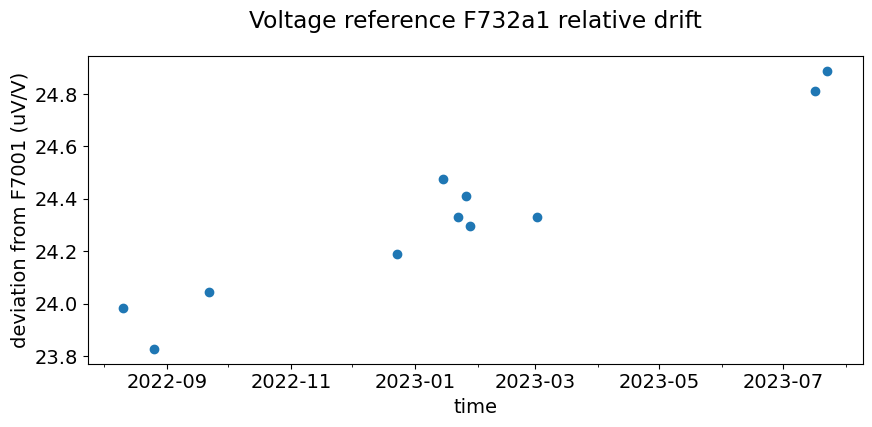

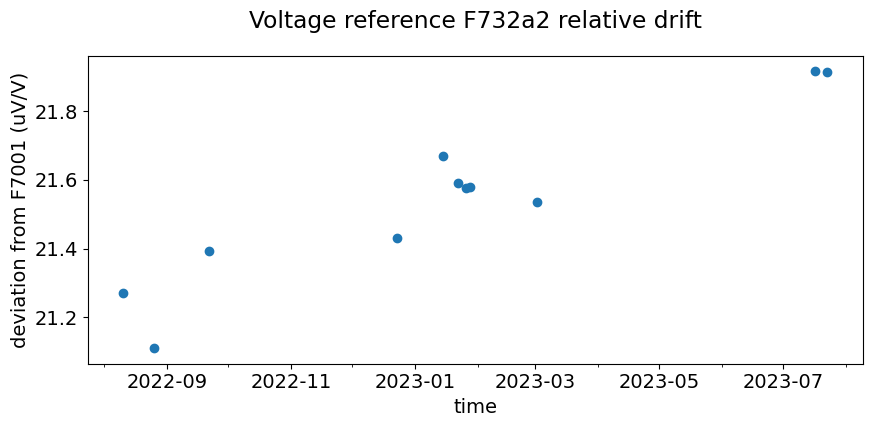

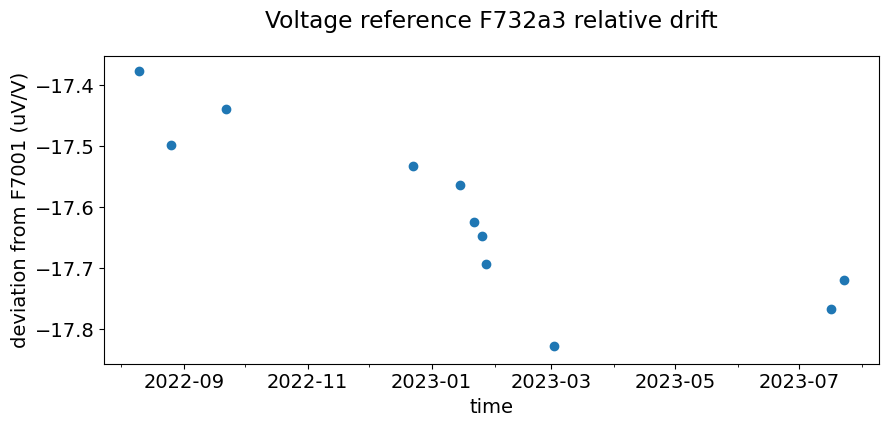

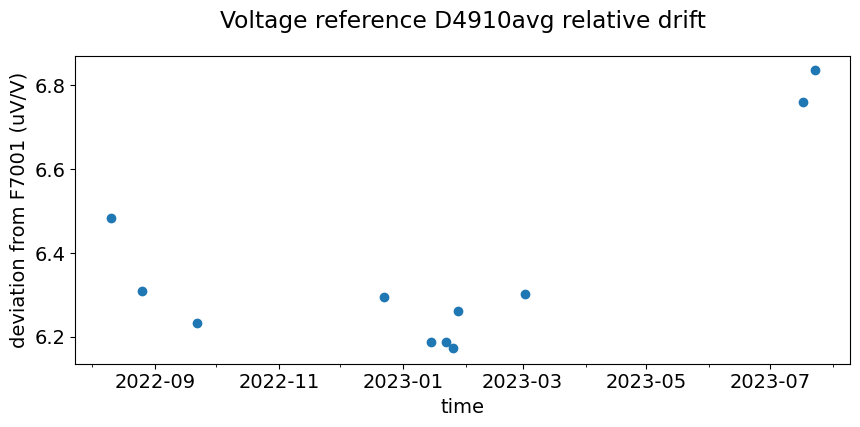

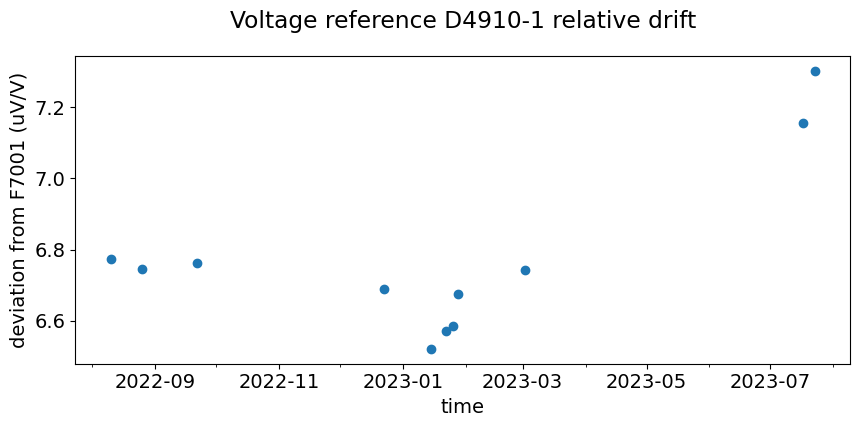

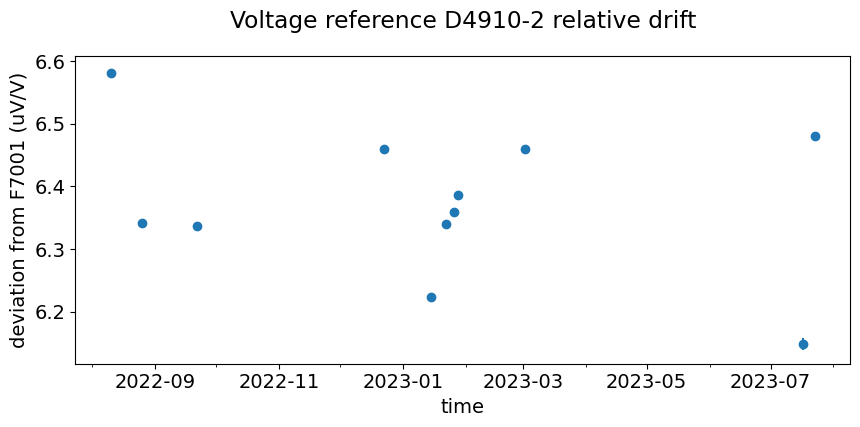

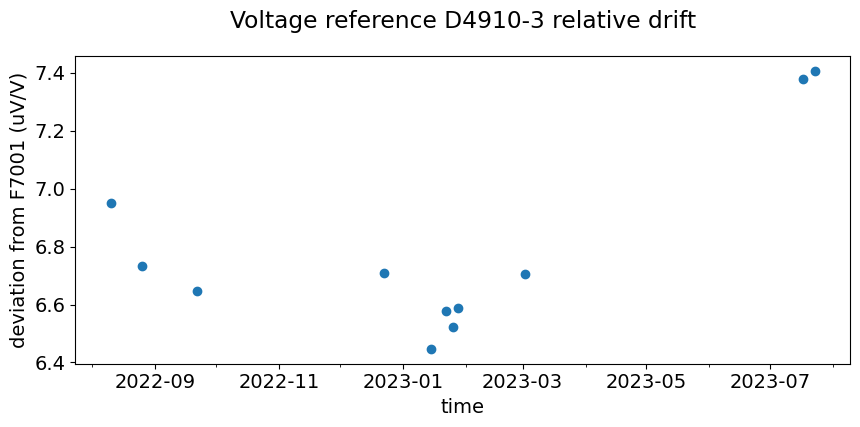

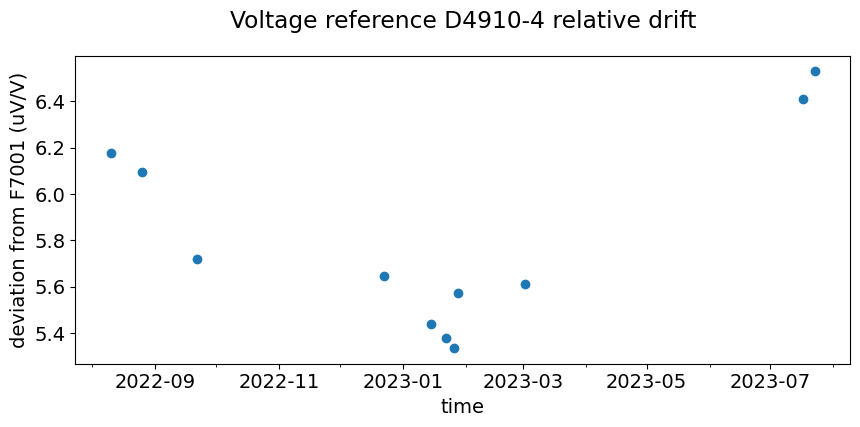

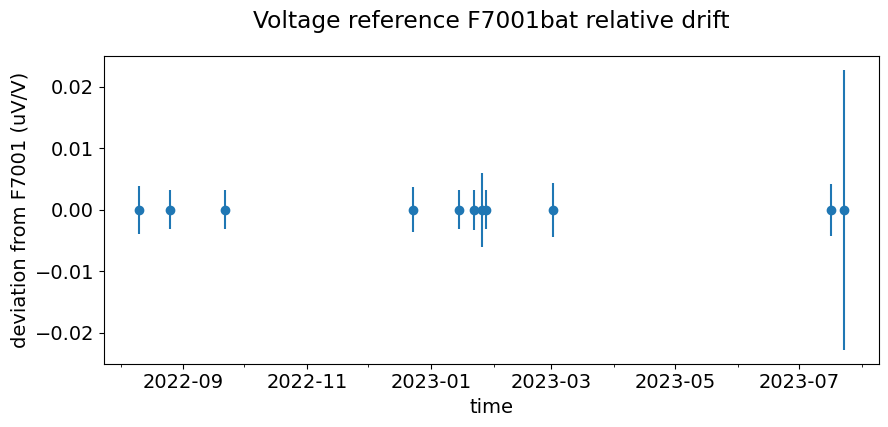

In [6]:
plt.rcParams["figure.figsize"] = (10,4)

# rel_results[[(ref, param) for ref in voltage_references for param in ('mean', 'sem', 'datetime')]]
rel_results = rel_results.dropna()
for ref in voltage_references:  
    plt.errorbar(rel_results[(ref, 'datetime')].dropna(), rel_results[(ref, 'mean')].dropna(), yerr=rel_results[(ref, 'sem')].dropna(), label=ref, fmt='o')
    plt.xlabel('time')
    plt.ylabel('deviation from F7001 (uV/V)')
    plt.title(f'Voltage reference {ref} relative drift', pad=20)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    plt.show()

# Misc analyses

## Check groupings

### k182_relative_data

In [7]:
orig_max_rows = pd.get_option('display.max_rows')
# pd.set_option('display.max_rows', None)
duration_data = k182_rel_data_cut.reset_index().groupby(['group', 'dut_neg_lead', 'dut_pos_lead']).agg({'datetime': ['min', 'max', 'mean']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
# pd.set_option('display.max_rows', orig_max_rows)
all_duration_data = duration_data

datetime  \
                                                       min   
group dut_neg_lead dut_pos_lead                              
0     F732a3       short        2022-08-25 10:54:36.345585   
      F7001bat     F732a3       2022-08-25 11:10:49.192938   
      F732a3       F7001bat     2022-08-25 11:11:47.817884   
      F7001bat     F732a2       2022-08-25 11:15:00.538933   
      F732a2       F7001bat     2022-08-25 11:16:11.098328   
...                                                    ...   
15    D4910avg     D4910-2      2023-07-23 00:27:43.832143   
                   D4910-3      2023-07-23 00:34:19.690410   
      D4910-3      D4910avg     2023-07-23 00:36:42.098104   
      D4910-4      D4910avg     2023-07-23 00:38:11.381512   
      D4910avg     D4910-4      2023-07-23 00:41:12.710423   

                                                            \
                                                       max   
group dut_neg_lead dut_pos_lead                              
0     F732a3       short        2022-08-25 11:06:46.667221   
      F7001bat     F732a3       2022-08-25 11:58:48.855236   
      F732a3       F7001bat     2022-08-25 11:50:50.202934   
      F7001bat     F732a2       2022-08-25 11:15:30.455669   
      F732a2       F7001bat     2022-08-25 12:13:37.153488   
...                                                    ...   
15    D4910avg     D4910-2      2023-07-23 00:29:47.452313   
                   D4910-3      2023-07-23 00:35:48.482019   
      D4910-3      D4910avg     2023-07-23 00:37:40.586178   
      D4910-4      D4910avg     2023-07-23 00:40:14.257169   
      D4910avg     D4910-4      2023-07-23 00:43:41.299239   

                                                               \
                                                         mean   
group dut_neg_lead dut_pos_lead                                 
0     F732a3       short        2022-08-25 11:00:41.953482496   
      F7001bat     F732a3       2022-08-25 11:52:51.826954752   
      F732a3       F7001bat     2022-08-25 11:35:25.070860288   
      F7001bat     F732a2       2022-08-25 11:15:15.487952896   
      F732a2       F7001bat     2022-08-25 12:01:40.469089792   
...                                                       ...   
15    D4910avg     D4910-2      2023-07-23 00:28:53.957512704   
                   D4910-3      2023-07-23 00:35:06.548655872   
      D4910-3      D4910avg     2023-07-23 00:37:11.360334592   
      D4910-4      D4910avg     2023-07-23 00:39:13.210990848   
      D4910avg     D4910-4      2023-07-23 00:42:25.511522560   

                                              duration  
                                                        
group dut_neg_lead dut_pos_lead                         
0     F732a3       short        0 days 00:12:10.321636  
      F7001bat     F732a3       0 days 00:47:59.662298  
      F732a3       F7001bat     0 days 00:39:02.385050  
      F7001bat     F732a2       0 days 00:00:29.916736  
      F732a2       F7001bat     0 days 00:57:26.055160  
...                                                ...  
15    D4910avg     D4910-2      0 days 00:02:03.620170  
                   D4910-3      0 days 00:01:28.791609  
      D4910-3      D4910avg     0 days 00:00:58.488074  
      D4910-4      D4910avg     0 days 00:02:02.875657  
      D4910avg     D4910-4      0 days 00:02:28.588816  

[312 rows x 4 columns]

### ag3458a_rel_data

In [8]:
orig_max_rows = pd.get_option('display.max_rows')
# pd.set_option('display.max_rows', None)
duration_data = ag3458a_rel_data.reset_index().groupby(['group', 'dut_neg_lead', 'dut_pos_lead']).agg({'datetime': ['min', 'max', 'mean']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
# pd.set_option('display.max_rows', orig_max_rows)
all_duration_data = pd.concat([all_duration_data, duration_data])
all_duration_data

datetime  \
                                                       min   
group dut_neg_lead dut_pos_lead                              
0     D4910avg     F7001bat     2022-08-10 01:28:59.711916   
      F7001bat     D4910avg     2022-08-10 01:33:52.224816   
                   D4910-1      2022-08-10 01:44:02.558776   
      D4910-1      F7001bat     2022-08-10 01:51:36.222159   
      D4910-2      F7001bat     2022-08-10 01:59:20.068137   
      F7001bat     D4910-2      2022-08-10 02:06:14.304998   
                   D4910-3      2022-08-10 02:09:04.730457   
      D4910-3      F7001bat     2022-08-10 02:14:15.811525   
      D4910-4      F7001bat     2022-08-10 02:17:17.205464   
      F7001bat     D4910-4      2022-08-10 02:20:17.535474   
      F732a1       F7001bat     2022-08-10 02:38:57.622169   
      F7001bat     F732a1       2022-08-10 02:43:22.142429   
                   F732a3       2022-08-10 02:48:29.379110   
      F732a3       F7001bat     2022-08-10 02:52:15.031834   
      F732a2       F7001bat     2022-08-10 02:56:37.414828   
      F7001bat     F732a2       2022-08-10 03:03:27.922068   

                                                            \
                                                       max   
group dut_neg_lead dut_pos_lead                              
0     D4910avg     F7001bat     2022-08-10 03:18:04.621361   
      F7001bat     D4910avg     2022-08-10 03:12:03.621322   
                   D4910-1      2022-08-10 01:50:18.250952   
      D4910-1      F7001bat     2022-08-10 01:54:08.639030   
      D4910-2      F7001bat     2022-08-10 02:01:01.371553   
      F7001bat     D4910-2      2022-08-10 02:08:26.091012   
                   D4910-3      2022-08-10 02:11:31.643546   
      D4910-3      F7001bat     2022-08-10 02:16:12.291561   
      D4910-4      F7001bat     2022-08-10 02:19:03.577417   
      F7001bat     D4910-4      2022-08-10 02:22:31.001556   
      F732a1       F7001bat     2022-08-10 02:40:33.865399   
      F7001bat     F732a1       2022-08-10 02:45:23.708859   
                   F732a3       2022-08-10 02:50:51.225480   
      F732a3       F7001bat     2022-08-10 02:54:42.003983   
      F732a2       F7001bat     2022-08-10 02:59:14.445236   
      F7001bat     F732a2       2022-08-10 03:06:25.205327   

                                                               \
                                                         mean   
group dut_neg_lead dut_pos_lead                                 
0     D4910avg     F7001bat     2022-08-10 02:32:04.596553728   
      F7001bat     D4910avg     2022-08-10 02:11:42.607617792   
                   D4910-1      2022-08-10 01:47:10.186413312   
      D4910-1      F7001bat     2022-08-10 01:52:52.418054144   
      D4910-2      F7001bat     2022-08-10 02:00:10.719646464   
      F7001bat     D4910-2      2022-08-10 02:07:20.208248320   
                   D4910-3      2022-08-10 02:10:18.190561792   
      D4910-3      F7001bat     2022-08-10 02:15:14.054734080   
      D4910-4      F7001bat     2022-08-10 02:18:10.389515264   
      F7001bat     D4910-4      2022-08-10 02:21:23.762162944   
      F732a1       F7001bat     2022-08-10 02:39:45.735740672   
      F7001bat     F732a1       2022-08-10 02:44:22.916991232   
                   F732a3       2022-08-10 02:49:40.302406656   
      F732a3       F7001bat     2022-08-10 02:53:28.516777216   
      F732a2       F7001bat     2022-08-10 02:57:55.923575296   
      F7001bat     F732a2       2022-08-10 03:04:56.557348352   

                                              duration  
                                                        
group dut_neg_lead dut_pos_lead                         
0     D4910avg     F7001bat     0 days 01:49:04.909445  
      F7001bat     D4910avg     0 days 01:38:11.396506  
                   D4910-1      0 days 00:06:15.692176  
      D4910-1      F7001bat     0 days 00:02:32.416871  
      D4910-2      F7001bat     0 days 00:01:41.303416  


datetime  \
                                                       min   
group dut_neg_lead dut_pos_lead                              
0     D4910-1      F7001bat     2022-08-25 12:26:34.963214   
      D4910-2      F7001bat     2022-08-25 12:27:26.435180   
      D4910-3      F7001bat     2022-08-25 12:31:39.562114   
      D4910-4      F7001bat     2022-08-25 12:33:50.013982   
      D4910avg     F7001bat     2022-08-25 12:17:05.303089   
...                                                    ...   
      F7001bat     F732a2       2022-08-10 03:03:27.922068   
                   F732a3       2022-08-10 02:48:29.379110   
      F732a1       F7001bat     2022-08-10 02:38:57.622169   
      F732a2       F7001bat     2022-08-10 02:56:37.414828   
      F732a3       F7001bat     2022-08-10 02:52:15.031834   

                                                            \
                                                       max   
group dut_neg_lead dut_pos_lead                              
0     D4910-1      F7001bat     2022-08-25 12:26:58.923490   
      D4910-2      F7001bat     2022-08-25 12:28:30.836231   
      D4910-3      F7001bat     2022-08-25 12:32:17.286253   
      D4910-4      F7001bat     2022-08-25 12:35:40.598801   
      D4910avg     F7001bat     2022-08-25 12:48:17.064275   
...                                                    ...   
      F7001bat     F732a2       2022-08-10 03:06:25.205327   
                   F732a3       2022-08-10 02:50:51.225480   
      F732a1       F7001bat     2022-08-10 02:40:33.865399   
      F732a2       F7001bat     2022-08-10 02:59:14.445236   
      F732a3       F7001bat     2022-08-10 02:54:42.003983   

                                                               \
                                                         mean   
group dut_neg_lead dut_pos_lead                                 
0     D4910-1      F7001bat     2022-08-25 12:26:47.326725376   
      D4910-2      F7001bat     2022-08-25 12:27:59.010249984   
      D4910-3      F7001bat     2022-08-25 12:31:57.739055104   
      D4910-4      F7001bat     2022-08-25 12:34:26.750688000   
      D4910avg     F7001bat     2022-08-25 12:39:47.189152000   
...                                                       ...   
      F7001bat     F732a2       2022-08-10 03:04:56.557348352   
                   F732a3       2022-08-10 02:49:40.302406656   
      F732a1       F7001bat     2022-08-10 02:39:45.735740672   
      F732a2       F7001bat     2022-08-10 02:57:55.923575296   
      F732a3       F7001bat     2022-08-10 02:53:28.516777216   

                                              duration  
                                                        
group dut_neg_lead dut_pos_lead                         
0     D4910-1      F7001bat     0 days 00:00:23.960276  
      D4910-2      F7001bat     0 days 00:01:04.401051  
      D4910-3      F7001bat     0 days 00:00:37.724139  
      D4910-4      F7001bat     0 days 00:01:50.584819  
      D4910avg     F7001bat     0 days 00:31:11.761186  
...                                                ...  
      F7001bat     F732a2       0 days 00:02:57.283259  
                   F732a3       0 days 00:02:21.846370  
      F732a1       F7001bat     0 days 00:01:36.243230  
      F732a2       F7001bat     0 days 00:02:37.030408  
      F732a3       F7001bat     0 days 00:02:26.972149  

[328 rows x 4 columns]

### ag3458a_1_abs_data

In [9]:
orig_max_rows = pd.get_option('display.max_rows')
# pd.set_option('display.max_rows', None)
data_with_neg_lead = ag3458a_1_abs_data_cut.reset_index().rename(columns={'dut': 'dut_pos_lead'})
data_with_neg_lead['dut_neg_lead'] = 'ag3458a_1'
duration_data = data_with_neg_lead.groupby(['group', 'dut_neg_lead', 'dut_pos_lead']).agg({'datetime': ['min', 'max', 'mean']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
# pd.set_option('display.max_rows', orig_max_rows)
np.unique(ag3458a_1_abs_data_cut[ag3458a_1_abs_data_cut.group == 2].index.date)
all_duration_data = pd.concat([all_duration_data, duration_data])

datetime  \
                                                         min   
group dut_neg_lead dut_pos_lead                                
0     ag3458a_1    D4910avg       2021-09-13 01:13:07.779134   
1     ag3458a_1    D4910avg       2021-11-15 12:02:46.347705   
2     ag3458a_1    D4910avg       2021-11-17 21:34:21.608514   
                   D4910-1        2021-11-17 21:43:40.639165   
                   D4910-2        2021-11-17 21:52:13.707073   
...                                                      ...   
12    ag3458a_1    LT1021CMH-10-1 2023-07-17 00:59:54.397832   
                   LT1021CMH-10-2 2023-07-17 01:06:44.000818   
                   LT1021CMH-10-3 2023-07-17 01:11:09.106796   
                   LT1021CMH-10-4 2023-07-17 01:18:12.980195   
                   LT1021CMH-10-5 2023-07-17 01:23:33.599174   

                                                              \
                                                         max   
group dut_neg_lead dut_pos_lead                                
0     ag3458a_1    D4910avg       2021-09-13 01:19:14.231825   
1     ag3458a_1    D4910avg       2021-11-15 13:59:46.780667   
2     ag3458a_1    D4910avg       2021-11-17 23:41:11.154469   
                   D4910-1        2021-11-17 21:51:22.598264   
                   D4910-2        2021-11-17 22:00:23.203927   
...                                                      ...   
12    ag3458a_1    LT1021CMH-10-1 2023-07-17 01:02:38.444495   
                   LT1021CMH-10-2 2023-07-17 01:09:56.845231   
                   LT1021CMH-10-3 2023-07-17 01:15:11.084452   
                   LT1021CMH-10-4 2023-07-17 01:22:02.705911   
                   LT1021CMH-10-5 2023-07-17 01:29:18.216491   

                                                                 \
                                                           mean   
group dut_neg_lead dut_pos_lead                                   
0     ag3458a_1    D4910avg       2021-09-13 01:16:11.109984256   
1     ag3458a_1    D4910avg       2021-11-15 12:21:11.694705664   
2     ag3458a_1    D4910avg       2021-11-17 22:37:49.348003584   
                   D4910-1        2021-11-17 21:47:29.652073984   
                   D4910-2        2021-11-17 21:56:24.790477312   
...                                                         ...   
12    ag3458a_1    LT1021CMH-10-1 2023-07-17 01:01:16.426112000   
                   LT1021CMH-10-2 2023-07-17 01:08:20.418955264   
                   LT1021CMH-10-3 2023-07-17 01:13:10.100621568   
                   LT1021CMH-10-4 2023-07-17 01:20:07.833321984   
                   LT1021CMH-10-5 2023-07-17 01:26:25.873496576   

                                                duration  
                                                          
group dut_neg_lead dut_pos_lead                           
0     ag3458a_1    D4910avg       0 days 00:06:06.452691  
1     ag3458a_1    D4910avg       0 days 01:57:00.432962  
2     ag3458a_1    D4910avg       0 days 02:06:49.545955  
                   D4910-1        0 days 00:07:41.959099  
                   D4910-2        0 days 00:08:09.496854  
...                                                  ...  
12    ag3458a_1    LT1021CMH-10-1 0 days 00:02:44.046663  
                   LT1021CMH-10-2 0 days 00:03:12.844413  
                   LT1021CMH-10-3 0 days 00:04:01.977656  
                   LT1021CMH-10-4 0 days 00:03:49.725716  
                   LT1021CMH-10-5 0 days 00:05:44.617317  

[128 rows x 4 columns]

### ag3458a_2_abs_data

In [10]:
orig_max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', None)
data_with_neg_lead = ag3458a_2_abs_data.reset_index().rename(columns={'dut': 'dut_pos_lead'})
data_with_neg_lead['dut_neg_lead'] = 'ag3458a_2'
duration_data = data_with_neg_lead.groupby(['group', 'dut_neg_lead', 'dut_pos_lead']).agg({'datetime': ['min', 'max', 'mean']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
pd.set_option('display.max_rows', orig_max_rows)
all_duration_data = pd.concat([all_duration_data, duration_data])

datetime  \
                                                             min   
group dut_neg_lead dut_pos_lead                                    
0     ag3458a_2    F7001-SMPS-Au799ln 2021-09-10 10:01:16.672755   
                   F732a2             2021-09-10 10:03:24.330000   
                   D4910avg           2021-09-10 10:04:52.182880   
1     ag3458a_2    D4910avg           2021-09-12 22:17:33.380947   
                   F7001              2021-09-12 22:43:20.135285   
                   F7001-SMPS-Au799ln 2021-09-12 22:51:43.314149   
                   F732a2             2021-09-12 23:01:35.691370   
                   F732a1             2021-09-12 23:06:29.808999   
                   F732a3             2021-09-12 23:12:47.715171   
2     ag3458a_2    F7001bat           2022-12-25 02:39:14.842788   
3     ag3458a_2    F7001bat           2023-07-17 01:54:35.303091   

                                                                  \
                                                             max   
group dut_neg_lead dut_pos_lead                                    
0     ag3458a_2    F7001-SMPS-Au799ln 2021-09-10 10:02:37.092581   
                   F732a2             2021-09-10 10:03:54.487813   
                   D4910avg           2021-09-10 10:07:53.086176   
1     ag3458a_2    D4910avg           2021-09-13 01:39:51.978332   
                   F7001              2021-09-12 23:35:48.901632   
                   F7001-SMPS-Au799ln 2021-09-12 22:56:34.825195   
                   F732a2             2021-09-12 23:31:53.970455   
                   F732a1             2021-09-12 23:27:52.888710   
                   F732a3             2021-09-12 23:23:01.281511   
2     ag3458a_2    F7001bat           2022-12-25 03:00:32.842690   
3     ag3458a_2    F7001bat           2023-07-17 02:11:27.059450   

                                                                     \
                                                               mean   
group dut_neg_lead dut_pos_lead                                       
0     ag3458a_2    F7001-SMPS-Au799ln 2021-09-10 10:01:56.882341376   
                   F732a2             2021-09-10 10:03:39.407108608   
                   D4910avg           2021-09-10 10:06:22.641925120   
1     ag3458a_2    D4910avg           2021-09-13 00:37:03.027739392   
                   F7001              2021-09-12 23:03:46.068179200   
                   F7001-SMPS-Au799ln 2021-09-12 22:54:09.071528704   
                   F732a2             2021-09-12 23:16:44.824498176   
                   F732a1             2021-09-12 23:15:57.327261952   
                   F732a3             2021-09-12 23:17:40.807410176   
2     ag3458a_2    F7001bat           2022-12-25 02:50:37.810305280   
3     ag3458a_2    F7001bat           2023-07-17 02:02:48.841576960   

                                                    duration  
                                                              
group dut_neg_lead dut_pos_lead                               
0     ag3458a_2    F7001-SMPS-Au799ln 0 days 00:01:20.419826  
                   F732a2             0 days 00:00:30.157813  
                   D4910avg           0 days 00:03:00.903296  
1     ag3458a_2    D4910avg           0 days 03:22:18.597385  
                   F7001              0 days 00:52:28.766347  
                   F7001-SMPS-Au799ln 0 days 00:04:51.511046  
                   F732a2             0 days 00:30:18.279085  
                   F732a1             0 days 00:21:23.079711  
                   F732a3             0 days 00:10:13.566340  
2     ag3458a_2    F7001bat           0 days 00:21:17.999902  
3     ag3458a_2    F7001bat           0 days 00:16:51.756359

### All duration data combined

In [11]:
orig_max_rows = pd.get_option('display.max_rows')
# pd.set_option('display.max_rows', None)
display(all_duration_data.sort_values(('datetime', 'min')))
# pd.set_option('display.max_rows', orig_max_rows)

datetime  \
                                                             min   
group dut_neg_lead dut_pos_lead                                    
0     ag3458a_2    F7001-SMPS-Au799ln 2021-09-10 10:01:16.672755   
                   F732a2             2021-09-10 10:03:24.330000   
                   D4910avg           2021-09-10 10:04:52.182880   
1     ag3458a_2    D4910avg           2021-09-12 22:17:33.380947   
                   F7001              2021-09-12 22:43:20.135285   
...                                                          ...   
15    D4910avg     D4910-2            2023-07-23 00:27:43.832143   
                   D4910-3            2023-07-23 00:34:19.690410   
      D4910-3      D4910avg           2023-07-23 00:36:42.098104   
      D4910-4      D4910avg           2023-07-23 00:38:11.381512   
      D4910avg     D4910-4            2023-07-23 00:41:12.710423   

                                                                  \
                                                             max   
group dut_neg_lead dut_pos_lead                                    
0     ag3458a_2    F7001-SMPS-Au799ln 2021-09-10 10:02:37.092581   
                   F732a2             2021-09-10 10:03:54.487813   
                   D4910avg           2021-09-10 10:07:53.086176   
1     ag3458a_2    D4910avg           2021-09-13 01:39:51.978332   
                   F7001              2021-09-12 23:35:48.901632   
...                                                          ...   
15    D4910avg     D4910-2            2023-07-23 00:29:47.452313   
                   D4910-3            2023-07-23 00:35:48.482019   
      D4910-3      D4910avg           2023-07-23 00:37:40.586178   
      D4910-4      D4910avg           2023-07-23 00:40:14.257169   
      D4910avg     D4910-4            2023-07-23 00:43:41.299239   

                                                                     \
                                                               mean   
group dut_neg_lead dut_pos_lead                                       
0     ag3458a_2    F7001-SMPS-Au799ln 2021-09-10 10:01:56.882341376   
                   F732a2             2021-09-10 10:03:39.407108608   
                   D4910avg           2021-09-10 10:06:22.641925120   
1     ag3458a_2    D4910avg           2021-09-13 00:37:03.027739392   
                   F7001              2021-09-12 23:03:46.068179200   
...                                                             ...   
15    D4910avg     D4910-2            2023-07-23 00:28:53.957512704   
                   D4910-3            2023-07-23 00:35:06.548655872   
      D4910-3      D4910avg           2023-07-23 00:37:11.360334592   
      D4910-4      D4910avg           2023-07-23 00:39:13.210990848   
      D4910avg     D4910-4            2023-07-23 00:42:25.511522560   

                                                    duration  
                                                              
group dut_neg_lead dut_pos_lead                               
0     ag3458a_2    F7001-SMPS-Au799ln 0 days 00:01:20.419826  
                   F732a2             0 days 00:00:30.157813  
                   D4910avg           0 days 00:03:00.903296  
1     ag3458a_2    D4910avg           0 days 03:22:18.597385  
                   F7001              0 days 00:52:28.766347  
...                                                      ...  
15    D4910avg     D4910-2            0 days 00:02:03.620170  
                   D4910-3            0 days 00:01:28.791609  
      D4910-3      D4910avg           0 days 00:00:58.488074  
      D4910-4      D4910avg           0 days 00:02:02.875657  
      D4910avg     D4910-4            0 days 00:02:28.588816  

[467 rows x 4 columns]

In [12]:
groups_by_48h = all_duration_data.reset_index().groupby([pd.Grouper(key=('datetime', 'mean'), freq="2D"), 'dut_neg_lead', 'dut_pos_lead']).agg({('datetime', 'min'): 'min', ('datetime', 'max'): 'max', ('duration',''): 'sum'}).dropna()
groups_by_48h_2 = all_duration_data.reset_index().groupby([pd.Grouper(key=('datetime', 'mean'), freq="2D", offset=pd.Timedelta("1 days")), 'dut_neg_lead', 'dut_pos_lead']).agg({('datetime', 'min'): 'min', ('datetime', 'max'): 'max', ('duration',''): 'sum'}).dropna()
display_full_df(groups_by_48h)
display_full_df(groups_by_48h_2)

datetime  \
                                                                        min   
(datetime, mean) dut_neg_lead dut_pos_lead                                    
2021-09-10       ag3458a_2    D4910avg           2021-09-10 10:04:52.182880   
                              F7001-SMPS-Au799ln 2021-09-10 10:01:16.672755   
                              F732a2             2021-09-10 10:03:24.330000   
2021-09-12       ag3458a_1    D4910avg           2021-09-13 01:13:07.779134   
                 ag3458a_2    D4910avg           2021-09-12 22:17:33.380947   
                              F7001              2021-09-12 22:43:20.135285   
                              F7001-SMPS-Au799ln 2021-09-12 22:51:43.314149   
                              F732a1             2021-09-12 23:06:29.808999   
                              F732a2             2021-09-12 23:01:35.691370   
                              F732a3             2021-09-12 23:12:47.715171   
2021-11-15       ag3458a_1    D4910avg           2021-11-15 12:02:46.347705   
2021-11-17       ag3458a_1    D4910-1            2021-11-17 21:43:40.639165   
                              D4910-2            2021-11-17 21:52:13.707073   
                              D4910-3            2021-11-17 22:01:03.708580   
                              D4910-4            2021-11-17 22:14:23.978300   
                              D4910avg           2021-11-17 21:34:21.608514   
                              F7001              2021-11-17 22:48:06.302977   
                              F7001bat           2021-11-17 23:42:01.955847   
                              F732a1             2021-11-17 22:56:50.634225   
                              F732a2             2021-11-17 23:16:40.332361   
                              F732a3             2021-11-17 23:06:15.396853   
2022-04-18       ag3458a_1    D4910-1            2022-04-19 01:09:49.794657   
                              D4910-2            2022-04-19 01:23:23.510141   
                              D4910-3            2022-04-19 01:35:26.978687   
                              D4910-4            2022-04-19 01:44:21.125066   
                              D4910avg           2022-04-18 21:35:24.253048   
                              F7001              2022-04-18 22:38:34.637707   
                              F732a1             2022-04-18 21:54:32.069056   
                              F732a2             2022-04-18 22:14:01.739416   
                              F732a3             2022-04-19 00:22:14.733987   
2022-08-08       ag3458a_1    F7001              2022-08-09 22:49:59.001239   
                              F7001bat           2022-08-09 22:57:56.888908   
                              F732a1             2022-08-09 23:54:17.381498   
                              F732a2             2022-08-09 23:32:39.433347   
                              F732a3             2022-08-09 23:42:32.575772   
2022-08-10       D4910-1      F7001bat           2022-08-10 01:51:36.222159   
                 D4910-2      F7001bat           2022-08-10 01:59:20.068137   
                 D4910-3      F7001bat           2022-08-10 02:14:15.811525   
                 D4910-4      F7001bat           2022-08-10 02:17:17.205464   
                 D4910avg     F7001bat           2022-08-10 01:28:59.711916   
                 F7001bat     D4910-1            2022-08-10 01:44:02.558776   
                              D4910-2            2022-08-10 02:06:14.304998   
                              D4910-3            2022-08-10 02:09:04.730457   
                              D4910-4            2022-08-10 02:20:17.535474   
                              D4910avg           2022-08-10 01:33:52.224816   
                              F732a1             2022-08-10 02:43:22.142429   
                              F732a2             2022-08-10 03:03:27.922068   
                              F732a3             2022-08-10 02:48:29.379110   
                 F732a1       F7001bat

datetime  \
                                                                        min   
(datetime, mean) dut_neg_lead dut_pos_lead                                    
2021-09-09       ag3458a_2    D4910avg           2021-09-10 10:04:52.182880   
                              F7001-SMPS-Au799ln 2021-09-10 10:01:16.672755   
                              F732a2             2021-09-10 10:03:24.330000   
2021-09-11       ag3458a_2    F7001              2021-09-12 22:43:20.135285   
                              F7001-SMPS-Au799ln 2021-09-12 22:51:43.314149   
                              F732a1             2021-09-12 23:06:29.808999   
                              F732a2             2021-09-12 23:01:35.691370   
                              F732a3             2021-09-12 23:12:47.715171   
2021-09-13       ag3458a_1    D4910avg           2021-09-13 01:13:07.779134   
                 ag3458a_2    D4910avg           2021-09-12 22:17:33.380947   
2021-11-14       ag3458a_1    D4910avg           2021-11-15 12:02:46.347705   
2021-11-16       ag3458a_1    D4910-1            2021-11-17 21:43:40.639165   
                              D4910-2            2021-11-17 21:52:13.707073   
                              D4910-3            2021-11-17 22:01:03.708580   
                              D4910-4            2021-11-17 22:14:23.978300   
                              D4910avg           2021-11-17 21:34:21.608514   
                              F7001              2021-11-17 22:48:06.302977   
                              F7001bat           2021-11-17 23:42:01.955847   
                              F732a1             2021-11-17 22:56:50.634225   
                              F732a2             2021-11-17 23:16:40.332361   
                              F732a3             2021-11-17 23:06:15.396853   
2022-04-17       ag3458a_1    F7001              2022-04-18 22:38:34.637707   
                              F732a1             2022-04-18 21:54:32.069056   
                              F732a2             2022-04-18 22:14:01.739416   
2022-04-19       ag3458a_1    D4910-1            2022-04-19 01:09:49.794657   
                              D4910-2            2022-04-19 01:23:23.510141   
                              D4910-3            2022-04-19 01:35:26.978687   
                              D4910-4            2022-04-19 01:44:21.125066   
                              D4910avg           2022-04-18 21:35:24.253048   
                              F732a3             2022-04-19 00:22:14.733987   
2022-08-09       D4910-1      F7001bat           2022-08-10 01:51:36.222159   
                 D4910-2      F7001bat           2022-08-10 01:59:20.068137   
                 D4910-3      F7001bat           2022-08-10 02:14:15.811525   
                 D4910-4      F7001bat           2022-08-10 02:17:17.205464   
                 D4910avg     F7001bat           2022-08-10 01:28:59.711916   
                 F7001bat     D4910-1            2022-08-10 01:44:02.558776   
                              D4910-2            2022-08-10 02:06:14.304998   
                              D4910-3            2022-08-10 02:09:04.730457   
                              D4910-4            2022-08-10 02:20:17.535474   
                              D4910avg           2022-08-10 01:33:52.224816   
                              F732a1             2022-08-10 02:43:22.142429   
                              F732a2             2022-08-10 03:03:27.922068   
                              F732a3             2022-08-10 02:48:29.379110   
                 F732a1       F7001bat           2022-08-10 02:38:57.622169   
                 F732a2       F7001bat           2022-08-10 02:56:37.414828   
                 F732a3       F7001bat           2022-08-10 02:52:15.031834   
                 ag3458a_1    D4910-1            2022-08-10 00:08:25.421378   
                              D4910-2            2022-08-10 00:23:37.371235   
                              D4910-3 

In [66]:
all_groups = pd.concat([groups_by_48h, groups_by_48h_2])
all_group_sets = all_groups.reset_index()[[('dut_neg_lead',''),('dut_pos_lead', ''), ('datetime', 'mean'), ('datetime', 'min'), ('datetime', 'max')]]
all_group_sets.columns = ['dut_neg_lead', 'dut_pos_lead', 'datetime', 'datetime_min', 'datetime_max']
all_group_sets_dates = all_group_sets.groupby('datetime').agg({'datetime_min': min, 'datetime_max': max})
all_group_sets_duts = all_group_sets.groupby('datetime').apply(lambda x: set(x.reset_index()[['dut_neg_lead', 'dut_pos_lead']].apply(lambda y: (y.dut_neg_lead, y.dut_pos_lead), axis=1).to_list()))
all_group_sets_grouped_by_date = all_group_sets_dates.join(all_group_sets_duts.rename('duts'), how='inner').reset_index()
all_group_sets_with_prev_and_next = pd.concat([all_group_sets_grouped_by_date, all_group_sets_grouped_by_date.shift(-1), all_group_sets_grouped_by_date.shift(1)], axis=1, keys=['current', 'next', 'prev'])
all_group_sets_with_prev_and_next
prev_group_within_1_day = (all_group_sets_with_prev_and_next[('current', 'datetime')] - all_group_sets_with_prev_and_next[('prev', 'datetime')] < pd.Timedelta('2 days'))
next_group_within_1_day = (all_group_sets_with_prev_and_next[('next', 'datetime')] - all_group_sets_with_prev_and_next[('current', 'datetime')] < pd.Timedelta('2 days'))
all_group_sets_with_prev_and_next.loc[~prev_group_within_1_day, ('prev', 'datetime')] = None
all_group_sets_with_prev_and_next.loc[~prev_group_within_1_day, ('prev', 'duts')] = np.nan
all_group_sets_with_prev_and_next.loc[~next_group_within_1_day, ('next', 'datetime')] = None
all_group_sets_with_prev_and_next.loc[~next_group_within_1_day, ('next', 'duts')] = np.nan
all_group_sets_with_prev_and_next['in_next'] = all_group_sets_with_prev_and_next.apply(lambda x: x[('current', 'duts')].issubset(x[('next', 'duts')]) if not pd.isna(x[('next', 'duts')]) else False, axis=1)
all_group_sets_with_prev_and_next['in_prev'] = all_group_sets_with_prev_and_next.apply(lambda x: x[('current', 'duts')].issubset(x[('prev', 'duts')]) if not pd.isna(x[('prev', 'duts')]) else False, axis=1)
all_group_sets_not_in_prev_or_current = all_group_sets_with_prev_and_next[~(all_group_sets_with_prev_and_next.in_prev | all_group_sets_with_prev_and_next.in_next)]
all_group_sets_not_in_prev_or_current

current                                                        \
     datetime               datetime_min               datetime_max   
3  2021-09-12 2021-09-12 22:17:33.380947 2021-09-13 01:39:51.978332   
10 2022-04-18 2022-04-18 21:35:24.253048 2022-04-19 02:11:31.926951   
13 2022-08-09 2022-08-09 22:49:59.001239 2022-08-10 03:18:04.621361   
16 2022-08-12 2022-08-12 20:23:16.362595 2022-08-13 01:56:29.962644   
23 2022-08-29 2022-08-29 08:24:27.698550 2022-08-30 02:30:26.882726   
26 2022-09-21 2022-09-21 14:38:34.325989 2022-09-22 20:19:30.200739   
27 2022-09-22 2022-09-21 23:06:34.223703 2022-09-24 00:34:58.759078   
28 2022-09-23 2022-09-22 21:39:14.015394 2022-09-25 03:04:08.015886   
29 2022-09-24 2022-09-24 00:36:27.794988 2022-09-25 12:00:46.317223   
30 2022-09-25 2022-09-25 03:04:47.840852 2022-09-26 22:20:45.326081   
41 2023-01-25 2023-01-25 22:18:41.265949 2023-01-26 08:34:59.796249   
43 2023-01-27 2023-01-27 23:23:57.145406 2023-01-28 16:08:23.099520   
50 2023-07-16 2023-07-16 19:47:15.798529 2023-07-17 02:27:26.072489   
53 2023-07-22 2023-07-22 22:10:56.961095 2023-07-23 00:49:48.040749   

                                                            next  \
                                                 duts   datetime   
3   {(ag3458a_1, D4910avg), (ag3458a_2, F732a3), (... 2021-09-13   
10  {(ag3458a_1, D4910-1), (ag3458a_1, F7001), (ag... 2022-04-19   
13  {(ag3458a_1, D4910-1), (F7001bat, D4910avg), (... 2022-08-10   
16  {(ag3458a_1, D4910-1), (ag3458a_1, D4910avg), ... 2022-08-13   
23  {(ag3458a_1, D4910-1), (F7001bat, D4910avg), (... 2022-08-30   
26  {(F7001bat, D4910avg), (D4910-4, D4910avg), (F... 2022-09-22   
27  {(ag3458a_1, D4910-2), (ag3458a_1, F732a3), (a... 2022-09-23   
28  {(ag3458a_1, D4910-2), (ag3458a_1, D4910-1), (... 2022-09-24   
29  {(ag3458a_1, D4910avg), (ag3458a_1, D4910-4), ... 2022-09-25   
30       {(ag3458a_1, D4910avg), (ag3458a_1, F732a1)} 2022-09-26   
41  {(F7001bat, D4910avg), (F732a3, F7001bat), (F7... 2023-01-26   
43  {(F7001bat, D4910avg), (D4910-4, D4910avg), (F... 2023-01-28   
50  {(ag3458a_1, AD587JQ-15), (ag3458a_1, AD587JQ-... 2023-07-17   
53  {(F7001bat, D4910avg), (D4910-4, D4910avg), (F... 2023-07-23   

                                                          \
                 datetime_min               datetime_max   
3  2021-09-12 22:17:33.380947 2021-09-13 01:39:51.978332   
10 2022-04-18 21:35:24.253048 2022-04-19 02:11:31.926951   
13 2022-08-09 23:11:15.475188 2022-08-10 03:18:04.621361   
16 2022-08-12 23:33:56.978725 2022-08-13 01:41:02.817084   
23 2022-08-30 00:03:44.611842 2022-08-30 02:30:26.882726   
26 2022-09-21 23:06:34.223703 2022-09-24 00:34:58.759078   
27 2022-09-22 21:39:14.015394 2022-09-25 03:04:08.015886   
28 2022-09-24 00:36:27.794988 2022-09-25 12:00:46.317223   
29 2022-09-25 03:04:47.840852 2022-09-26 22:20:45.326081   
30 2022-09-25 12:02:19.934422 2022-09-26 22:20:45.326081   
41 2023-01-25 22:32:00.120786 2023-01-28 00:13:02.775860   
43 2023-01-28 00:00:01.754080 2023-01-28 16:08:23.099520   
50 2023-07-17 00:01:39.642040 2023-07-17 02:11:27.059450   
53 2023-07-22 23:21:03.392104 2023-07-23 00:49:48.040749   

                                                            prev  \
                                                 duts   datetime   
3      {(ag3458a_1, D4910avg), (ag3458a_2, D4910avg)} 2021-09-11   
10  {(ag3458a_1, D4910-1), (ag3458a_1, D4910avg), ... 2022-04-17   
13  {(ag3458a_1, D4910-1), (F7001bat, D4910avg), (... 2022-08-08   
16  {(ag3458a_1, D4910avg), (ag3458a_1, F732a2), (... 2022-08-11   
23  {(D4910avg, D4910-2), (D4910-4, D4910avg), (D4... 2022-08-28   
26  {(ag3458a_1, D4910-2), (ag3458a_1, F732a3), (a... 2022-09-20   
27  {(ag3458a_1, D4910-2), (ag3458a_1, D4910-1), (... 2022-09-21   
28  {(ag3458a_1, D4910avg), (ag3458a_1, D4910-4), ... 2022-09-22   
29       {(ag3458a_1, D4910avg), (ag3458a_1, F732a1)} 2022-09-23   
30                              {(ag3458a_1, F732a1)} 2022-09-24   
41 

In [13]:
"""
k199-x2-3458A-x1-F732A-MV106-log.csv.bz2
datetime,k199_1_f732a_mv106,k199_2_f732a_therm,ag3458a_1_f732a,temp_1,last_acal_1,last_acal_1_cal72
2020-04-26
2020-10-14
k199-x2-3458A-x1-k2000-x2-6031A-D4910-F732A-x3-log.csv.bz2
datetime,k199_1_d4910_avg_2,k199_2_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_1_d4910_avg_f732a3,k2000_d4910_avg_4,k2000_20_d4910_avg_1,prema6031a_d4910_avg_f732a2
2021-04-18
2021-08-07
k199-x2-3458A-x2-F732A-MV106-log.csv.bz2
datetime,k199_1_f732a_mv106,k199_2_f732a_therm,ag3458a_1_f732a,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_f732a,temp_2,last_acal_2,last_acal_2_cal72
2018-12-08
2020-04-26
k199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x2-F7001-log.csv.bz2
datetime,k199_1_d4910_avg_2,k199_2_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_1_d4910_avg_f732a3,temp_2,last_acal_2,last_acal_2_cal72,ag3458a_2_d4910_avg_f7001,k2000_d4910_avg_4,k2000_20_d4910_avg_1,prema6031a_d4910_avg_f732a2
2021-08-07
2021-08-31
k199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x3-F7001-log.csv.bz2
datetime,k199_1_d4910_avg_2,k199_2_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_1_d4910_avg_f732a3,temp_2,last_acal_2,last_acal_2_cal72,ag3458a_2_d4910_avg_f7001,k2000_d4910_avg_f732a1,k2000_20_d4910_avg_1,prema6031a_d4910_avg_f732a2
2021-09-09
2021-09-10
k199-x2-3458A-x2-k2000-x2-D4910-F732A-MV106-log.csv.bz2
datetime,k199_1_f732a_mv106,k199_2_d4910_avg_4,ag3458a_1_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_f732a_d4910_avg,temp_2,last_acal_2,last_acal_2_cal72,k2000_d4910_avg_1,k2000_20_d4910_avg_2
2020-10-14
2020-12-20
k199-x2-3458A-x2-k2000-x2-D4910-F732A-x2-log.csv.bz2
datetime,k199_1_d4910_avg_2,k199_2_d4910_avg_3,ag3458a_2_f732a2_d4910_avg,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_1_f732a1_d4910_avg,temp_2,last_acal_2,last_acal_2_cal72,k2000_d4910_avg_4,k2000_20_d4910_avg_1
2020-12-21
2021-04-03
k199-x2-3458A-x2-k2000-x-D4910-F732A-MV106-log.csv.bz2
datetime,k199_1_f732a_mv106,k199_2_d4910_avg_4,ag3458a_1_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_f732a_d4910_avg,temp_2,last_acal_2,last_acal_2_cal72,k2000_d4910_avg_1,k2000_20_d4910_avg_2
2020-10-14
2020-10-14

3458A-x2-MV106.csv.bz2
datetime,ag3458a_1_mv106,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_mv106,temp_2,last_acal_2,last_acal_2_cal72
2018-06-30
2018-12-08
k199-x2-3456A-3458A-x2-F730A-6031A-8200-log.csv.bz2
datetime,ag3456a_ch1_2,k199_ch1_3,k199_ch1_4,ag3458a_1_ch1,temp_1,last_acal_1,last_acal_1_cal72,pr6031a_8200,ag3458a_2_ch1,temp_2,last_acal_2,last_acal_2_cal72
2018-02-27
2018-03-03
k199-x2-3458A-x2-F730A-6031A-8200-log.csv.bz2
datetime,k199_ch1_3,k199_ch1_4,ag3458a_1_ch1,temp_1,last_acal_1,last_acal_1_cal72,pr6031a_8200,ag3458a_2_ch1,temp_2,last_acal_2,last_acal_2_cal72
2018-03-03
2018-03-04
k199-x2-3458A-x2-F730A-PM2534-log.csv.bz2
datetime,pm2534_ch1_2,k199_ch1_3,k199_ch1_4,ag3458a_1_ch1,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_ch1,temp_2,last_acal_2,last_acal_2_cal72
2018-03-04
2018-03-31

"""

"""
k199-x2-3456A-3458A-x2-F730A-6031A-8200-log.csv.bz2
2018-02-27 - 2018-03-03: 2x 3458A
k199-x2-3458A-x2-F730A-6031A-8200-log.csv.bz2
2018-03-03 - 2018-03-04: 2x 3458A
k199-x2-3458A-x2-F730A-PM2534-log.csv.bz2
2018-03-04 - 2018-03-31: 2x 3458A
3458A-x2-MV106.csv.bz2
2018-06-30 - 2018-12-08: 2x 3458A
k199-x2-3458A-x2-F732A-MV106-log.csv.bz2
2018-12-08 - 2020-04-26: 2x 3458A, 1x F732A
k199-x2-3458A-x1-F732A-MV106-log.csv.bz2
2020-04-26 - 2020-10-14: 1x 3458A(_1), 1x F732A
k199-x2-3458A-x2-k2000-x-D4910-F732A-MV106-log.csv.bz2
k199-x2-3458A-x2-k2000-x2-D4910-F732A-MV106-log.csv.bz2
2020-10-14 - 2020-12-20: 2x 3458A, 1x F732A, D4910 avg, 1-4
k199-x2-3458A-x2-k2000-x2-D4910-F732A-x2-log.csv.bz2
2020-12-21 - 2021-04-03: 2x 3458A, 2x F732A, D4910 avg, 1-4
k199-x2-3458A-x1-k2000-x2-6031A-D4910-F732A-x3-log.csv.bz2
2021-04-18 - 2021-08-07: 1x 3458A(-1), 3x F732A, D4910 avg, 1-4
k199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x2-F7001-log.csv.bz2
2021-08-07 - 2021-08-31: 2x 3458A, 2x F732A, D4910 avg, 1-4, F7001
k199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x3-F7001-log.csv.bz2
2021-09-09 - 2021-09-10: 2x 3458A, 3x F732A, D4910 avg, 1-3, F7001
"""

'\nk199-x2-3456A-3458A-x2-F730A-6031A-8200-log.csv.bz2\n2018-02-27 - 2018-03-03: 2x 3458A\nk199-x2-3458A-x2-F730A-6031A-8200-log.csv.bz2\n2018-03-03 - 2018-03-04: 2x 3458A\nk199-x2-3458A-x2-F730A-PM2534-log.csv.bz2\n2018-03-04 - 2018-03-31: 2x 3458A\n3458A-x2-MV106.csv.bz2\n2018-06-30 - 2018-12-08: 2x 3458A\nk199-x2-3458A-x2-F732A-MV106-log.csv.bz2\n2018-12-08 - 2020-04-26: 2x 3458A, 1x F732A\nk199-x2-3458A-x1-F732A-MV106-log.csv.bz2\n2020-04-26 - 2020-10-14: 1x 3458A(_1), 1x F732A\nk199-x2-3458A-x2-k2000-x-D4910-F732A-MV106-log.csv.bz2\nk199-x2-3458A-x2-k2000-x2-D4910-F732A-MV106-log.csv.bz2\n2020-10-14 - 2020-12-20: 2x 3458A, 1x F732A, D4910 avg, 1-4\nk199-x2-3458A-x2-k2000-x2-D4910-F732A-x2-log.csv.bz2\n2020-12-21 - 2021-04-03: 2x 3458A, 2x F732A, D4910 avg, 1-4\nk199-x2-3458A-x1-k2000-x2-6031A-D4910-F732A-x3-log.csv.bz2\n2021-04-18 - 2021-08-07: 1x 3458A(-1), 3x F732A, D4910 avg, 1-4\nk199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x2-F7001-log.csv.bz2\n2021-08-07 - 2021-08-31: 2x 3458

## Check number of samples taken

In [14]:
rel_counts = add_dut_neg_and_pos_group(relative_data_k182).groupby('group')['dut_neg_lead'].count()

<Axes: ylabel='Frequency'>

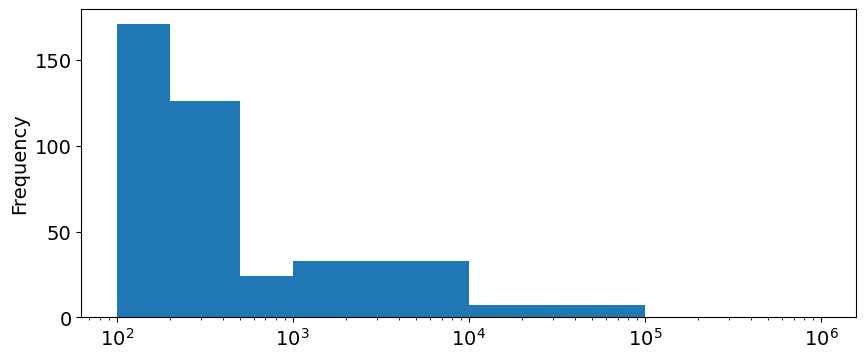

In [15]:
rel_counts.plot(kind="hist", logx=True, bins=[100,200, 500, 1e3,1e4,1e5,1e6])

In [16]:
relative_data_k182.groupby(by=['dut_pos_lead', 'dut_neg_lead']).count()

k182_dcv  temperature  pressure  humidity
dut_pos_lead dut_neg_lead                                           
D4190-3      D4910avg           191          191       191       191
D4190-4      D4910avg           201          201       201       201
D4700+10V    F7001bat           639          639       639       639
D4700-10V    F7001bat           817          817       817       817
D4910-1      D4910avg         11760        11760     11760     11760
             F7001bat          3417         3417      3417      3417
D4910-2      D4910avg          8322         8322      8322      8322
             F7001bat          2095         2095      2095      2095
D4910-3      D4910avg          3619         3619      3619      3619
             F7001bat          2033         2033      2033      2033
D4910-4      D4910avg          3778         3778      3778      3778
             F7001bat          2831         2831      2831      2831
D4910avg     D4190-2            230          230       230       230
             D4190-3            209          209       209       209
             D4190-4            135          135       135       135
             D4910-1           9254         9254      9254      9254
             D4910-2           7085         7085      7085      7085
             D4910-3           2859         2859      2859      2859
             D4910-4           2939         2939      2939      2939
             F7001bat         65484        65484     65484     65484
             F732a1            8456         8456      8456      8456
             F732a2         1174105      1174105   1174105   1174105
D4910avg-bat F7001bat           308          308       308       308
F7001bat     D4700+10V         1219         1219      1219      1219
             D4700-10V          726          726       726       726
             D4910-1           4249         4249      4249      4249
             D4910-2           2137         2137      2137      2137
             D4910-3           2423         2423      2423      2423
             D4910-4           1852         1852      1852      1852
             D4910avg         76664        76664     76664     76664
             F732a1            3150         3150      3150      3150
             F732a2           16105        16105     16105     16105
             F732a3            5066         5066      5066      5066
F732a1       D4910avg          7610         7610      7610      7610
             F7001bat          7602         7602      7602      7602
F732a2       D4910avg          8953         8953      8953      8953
             F7001bat          5661         5661      5661      5661
F732a3       F7001bat          6888         6888      6888      6888
short        D4910avg          3368         3368      3368      3368
             F732a2           20150        20150     20150     20150
             F732a3           27876        27876     27876     27876

## Check for sign flip

,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,
2023-01-27 23:23:57.145406,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,True,9,-1.0
2023-01-27 23:23:57.435250,D4910avg,F7001bat,-0.000064,28.689062,1030.115562,26.709386,False,9,-1.0
2023-01-27 23:23:57.693478,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,False,9,-1.0
2023-01-27 23:23:57.953854,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,False,9,-1.0
2023-01-27 23:23:58.217669,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,False,9,-1.0
...,...,...,...,...,...,...,...,...,...
2023-01-28 00:11:40.922407,D4910avg,F7001bat,-0.000063,28.384180,1030.115130,26.861672,False,9,-1.0
2023-01-28 00:11:41.214983,D4910avg,F7001bat,-0.000062,28.384180,1030.115130,26.861672,False,9,-1.0
2023-01-28 00:11:41.478905,D4910avg,F7001bat,-0.000062,28.384180,1030.115130,26.861672,False,9,-1.0


,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,


,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,


,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,
2023-01-27 23:24:49.593494,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:49.856018,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:50.120381,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:50.380210,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:50.638488,F7001bat,D4910avg,0.000064,28.663281,1030.173685,26.664547,False,9,1.0
...,...,...,...,...,...,...,...,...,...
2023-01-28 00:13:01.709912,F7001bat,D4910avg,0.000062,28.361914,1030.128611,26.868205,False,9,1.0
2023-01-28 00:13:01.971985,F7001bat,D4910avg,0.000062,28.361914,1030.128611,26.868205,False,9,1.0
2023-01-28 00:13:02.234607,F7001bat,D4910avg,0.000062,28.361914,1030.128611,26.868205,False,9,1.0


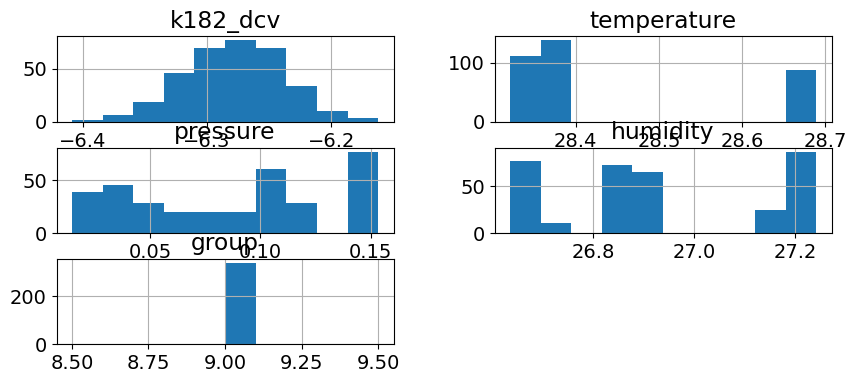

In [17]:
sample = k182_rel_data_cut[(k182_rel_data_cut.group == 9) & ((k182_rel_data_cut.dut_neg_lead == 'D4910avg') | (k182_rel_data_cut.dut_pos_lead == 'D4910avg')) & ((k182_rel_data_cut.dut_neg_lead == 'F7001bat') | (k182_rel_data_cut.dut_pos_lead == 'F7001bat'))].copy()
sample[sample.dut_pos_lead == 'F7001bat'].hist()
sample['sign'] = (sample.k182_dcv / sample.k182_dcv.abs())
res = sample.groupby(['dut_neg_lead', 'dut_pos_lead']).agg({'sign': 'unique'})
res['sign_length'] = res['sign'].apply(lambda r: len(r))
display(sample[(sample.dut_pos_lead == 'F7001bat') & (sample.k182_dcv < 0)])
display(sample[(sample.dut_pos_lead == 'F7001bat') & (sample.k182_dcv > 0)])
display(sample[(sample.dut_neg_lead == 'F7001bat') & (sample.k182_dcv < 0)])
display(sample[(sample.dut_neg_lead == 'F7001bat') & (sample.k182_dcv > 0)])